Check if the energy shift in the dinamics is explained by the polaron or by inefficient cooling.

In [21]:
%load_ext autoreload
%autoreload 2
import pickle
from datetime import datetime
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp
import sandbox_correct as sb
import importlib
importlib.reload(sb)
import sweeps as sweeps
importlib.reload(sweeps)
import glob
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
### Code to load einzel dynamics.

filepath = "diff_point2_low_diss/eff_coupling_5.5MHz.pkl"

with open(filepath, 'rb') as f:
    loaded_data = pickle.load(f)

print(f"Multi-dynamics loaded from: {filepath}", flush=True)
print(f"Description: {loaded_data['description']}", flush=True)
print(f"Timestamp: {loaded_data['timestamp']}", flush=True)

# Return all four dynamics types
dynamics_normal_shift = loaded_data['full_dynamics_normal_shift']
parameters = loaded_data['parameters']
if 'full_dynamics_polaron_shift' in loaded_data:
    dynamics_polaron_shift = loaded_data['full_dynamics_polaron_shift']

Multi-dynamics loaded from: diff_point2_low_diss/eff_coupling_5.5MHz.pkl
Description: Full-dynamics for eff_coupling=5.5MHz
Timestamp: 20251112_155359


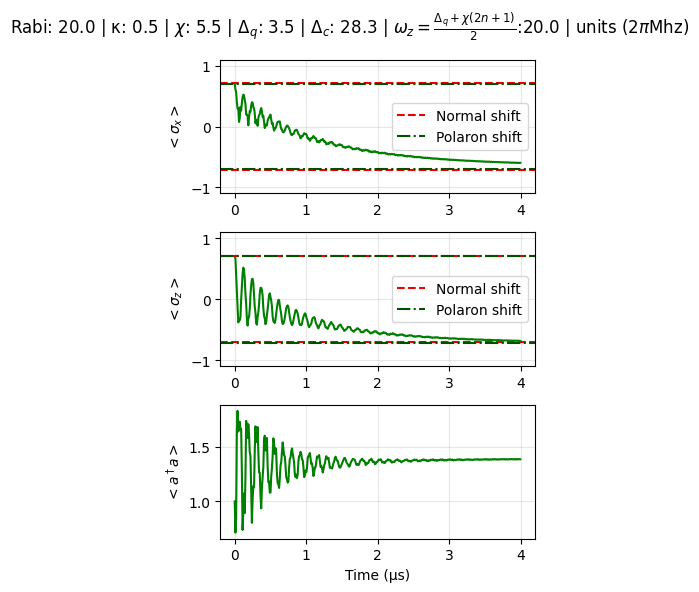

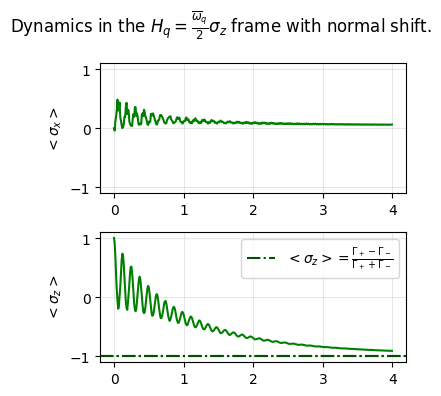

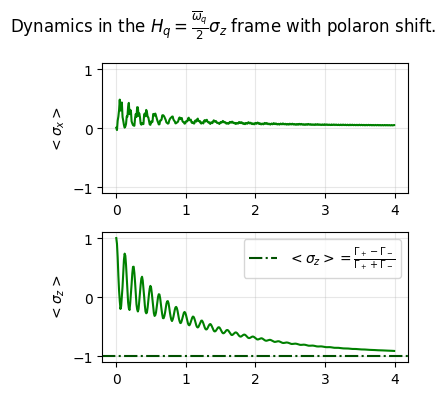

In [60]:
### Analisis for normal shift dynamics.

N = parameters['N']
cavity_diss_rate = parameters['cavity_diss_rate']
input_power = parameters['input_power']
rabi_freq = parameters['rabi_freq']
eff_coupling = parameters['eff_coupling']
qubit_targetz = parameters['qubit_targetz']
norm = parameters['norm']
final_time__mus = parameters['final_time__mus'] 
time_steps = parameters["time_steps"]
psi0_atom = parameters['initial_state_qubit']
tlist = np.linspace(0, final_time__mus, time_steps)

cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam()) 

x_exp = expect(sx, dynamics_normal_shift)
z_exp = expect(sz, dynamics_normal_shift)
photon_number = expect(d.dag()*d, dynamics_normal_shift)

H_qubit = sb.target_hamiltonian(parameters)
evalues_target, estates_target = H_qubit.eigenstates()
# For ground state
gs_sigmax = expect(sigmax(), estates_target[0])
gs_sigmaz = expect(sigmaz(), estates_target[0])

# For excited state
es_sigmax = expect(sigmax(), estates_target[1])
es_sigmaz = expect(sigmaz(), estates_target[1])

H_qubit_pol = sb.target_hamiltonian_polaron(parameters)
evalues_target_pol, estates_target_pol = H_qubit_pol.eigenstates()

# For ground state
gs_sigmax_pol = expect(sigmax(), estates_target_pol[0])
gs_sigmaz_pol = expect(sigmaz(), estates_target_pol[0])

# For excited state
es_sigmax_pol = expect(sigmax(), estates_target_pol[1])
es_sigmaz_pol = expect(sigmaz(), estates_target_pol[1])

qubit_dynamics = [ptrace(i, 1) for i in  dynamics_normal_shift]

theta = np.arctan2(rabi_freq, qubit_detuning_lamb_shift)
U = (1j * theta/2 * sigmay()).expm()

dynamics_non_polaron_frame = np.array([U*i*U.dag() for i in qubit_dynamics])
x_exp_non_polaron_frame = np.array([expect(sigmax(), i) for i in dynamics_non_polaron_frame])
z_exp_non_polaron_frame = np.array([expect(sigmaz(), i) for i in dynamics_non_polaron_frame])



cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)
qubit_detuning_lamb_shift_pol = qubit_detuning + eff_coupling*(2*np.real(cavity_field_g*np.conj(cavity_field_e))+ 1)


theta_pol = np.arctan2(rabi_freq, qubit_detuning_lamb_shift_pol)

U_pol = (1j * theta_pol/2 * sigmay()).expm()

dynamics_polaron_frame = np.array([U_pol*i*U_pol.dag() for i in qubit_dynamics])
x_exp_polaron_frame = np.array([expect(sigmax(), i) for i in dynamics_polaron_frame])
z_exp_polaron_frame = np.array([expect(sigmaz(), i) for i in dynamics_polaron_frame])

diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
#Get rates according to the normal shift hamiltonian.
num1 = rabi_freq**2*cavity_photon_number*eff_coupling**2*cavity_diss_rate
den_ex_rate = diag_qubit_freq**2*((diag_qubit_freq + cavity_detuning)**2+(cavity_diss_rate/2)**2) 
den_de_rate = diag_qubit_freq**2*((diag_qubit_freq - cavity_detuning)**2+(cavity_diss_rate/2)**2) 

eff_qubit_excitation_rate = num1/den_ex_rate
eff_qubit_decay_rate = num1/den_de_rate

exp_z_rates = (eff_qubit_excitation_rate - eff_qubit_decay_rate)/(eff_qubit_excitation_rate + eff_qubit_decay_rate)

diag_qubit_freq_pol = (qubit_detuning_lamb_shift_pol**2 + rabi_freq**2)**.5
#Get rates according to the polaron shift hamiltonian.
den_ex_rate_pol = diag_qubit_freq_pol**2*((diag_qubit_freq_pol + cavity_detuning)**2+(cavity_diss_rate/2)**2) 
den_de_rate_pol = diag_qubit_freq_pol**2*((diag_qubit_freq_pol - cavity_detuning)**2+(cavity_diss_rate/2)**2) 

eff_qubit_excitation_rate_pol = num1/den_ex_rate_pol
eff_qubit_decay_rate_pol = num1/den_de_rate_pol

exp_z_rates_pol = (eff_qubit_excitation_rate - eff_qubit_decay_rate)/(eff_qubit_excitation_rate + eff_qubit_decay_rate)


# Generate plot
max_time = 4
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp[time_mask], color='#008000')
axes[1].plot(tlist_plot, z_exp[time_mask], color='#008000')
axes[2].plot(tlist_plot, photon_number[time_mask], color='#008000')

#compare with target hamiltonian expecation values:
axes[0].axhline(gs_sigmax,  ls='--', color='#EE0000', label="Normal shift")
axes[0].axhline(es_sigmax, ls='--', color='#EE0000')
axes[1].axhline(gs_sigmaz, ls='--', color='#EE0000', label="Normal shift")
axes[1].axhline(es_sigmaz, ls='--', color='#EE0000')

axes[0].axhline(gs_sigmax_pol, ls='-.', color='#005000', label="Polaron shift")
axes[0].axhline(es_sigmax_pol, ls='-.', color='#005000')
axes[1].axhline(gs_sigmaz_pol, ls='-.', color='#005000', label="Polaron shift")
axes[1].axhline(es_sigmaz_pol, ls='-.', color='#005000')

# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].grid(True, alpha=0.3)


params_text = []
params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\omega_z =\frac{\Delta_q +\chi(2n+1)}{2}$:"+f"{qubit_targetz/(2*np.pi*1e6):.1f}")


params_text.append(r"units (2$\pi$Mhz)")

plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()

fig1, axes1 = plt.subplots(2, 1, figsize=(4, 4))

params_text = []
params_text.append(r"Dynamics in the $H_q = \frac{\overline{\omega}_q}{2}\sigma_z$ frame with normal shift.")


axes1[0].plot(tlist_plot, x_exp_non_polaron_frame[time_mask], color='#008000')
axes1[1].plot(tlist_plot, z_exp_non_polaron_frame[time_mask], color='#008000')

# Format σ_x plot
axes1[0].set_ylabel(r'$<\sigma_x>$')
axes1[0].set_ylim(-1.1, 1.1)
axes1[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes1[1].set_ylabel(r'$<\sigma_z>$')
axes1[1].set_ylim(-1.1, 1.1)
axes1[1].grid(True, alpha=0.3)
axes1[1].axhline(exp_z_rates, ls='-.', color='#005000')
axes1[1].axhline(exp_z_rates_pol, ls='-.', color='#005000', label=r"$<\sigma_z> = \frac{\Gamma_+ - \Gamma_-}{\Gamma_+ + \Gamma_-}$")
axes1[1].legend()

plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()

fig2, axes2 = plt.subplots(2, 1, figsize=(4, 4))

axes2[0].plot(tlist_plot, x_exp_polaron_frame[time_mask], color='#008000')
axes2[1].plot(tlist_plot, z_exp_polaron_frame[time_mask], color='#008000')

# Format σ_x plot
axes2[0].set_ylabel(r'$<\sigma_x>$')
axes2[0].set_ylim(-1.1, 1.1)
axes2[0].grid(True, alpha=0.3)


# Format σ_z plot  
axes2[1].set_ylabel(r'$<\sigma_z>$')
axes2[1].set_ylim(-1.1, 1.1)
axes2[1].grid(True, alpha=0.3)
axes2[1].axhline(exp_z_rates_pol, ls='-.', color='#005000', label=r"$<\sigma_z> = \frac{\Gamma_+ - \Gamma_-}{\Gamma_+ + \Gamma_-}$")
axes2[1].legend()

params_text = []
params_text.append(r"Dynamics in the $H_q = \frac{\overline{\omega}_q}{2}\sigma_z$ frame with polaron shift.")
plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()




Analyzing dynamics in folder: diff_point2_low_diss

=== Summary ===
Couplings analyzed: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5]
Fidelity (normal): [0.99973924 0.99940967 0.99892717 0.99827974 0.99745777 0.99645671
 0.99528062 0.99394696 0.99249133 0.99096954]
Fidelity (polaron): [0.99973926 0.99940983 0.99892787 0.99828192 0.99746336 0.99646919
 0.99530567 0.99399331 0.99257191 0.99110244]


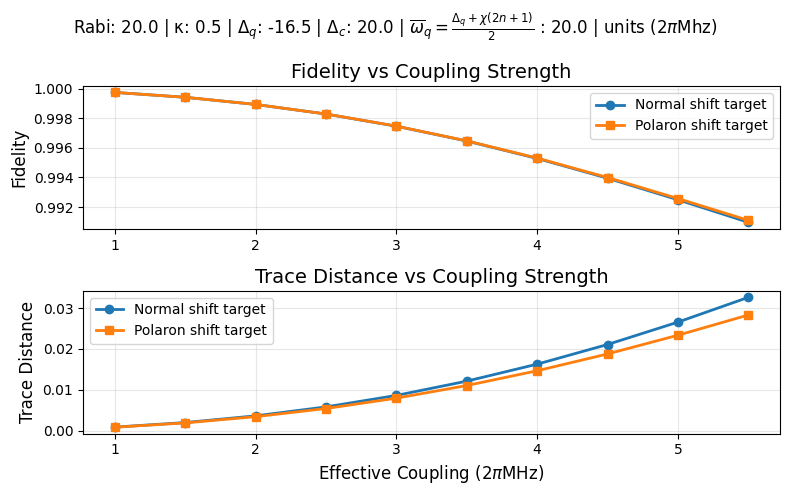

In [47]:
folder_path = "diff_point2_low_diss"  # Change this to your folder path
    
print(f"Analyzing dynamics in folder: {folder_path}")
results = sweeps.analyze_coupling_dependence(folder_path)

if results is not None:
    # Print summary
    print("\n=== Summary ===")
    print(f"Couplings analyzed: {results['couplings']}")
    print(f"Fidelity (normal): {results['fidelity_normal']}")
    print(f"Fidelity (polaron): {results['fidelity_polaron']}")
    
    # Create plots
    fig = sweeps.plot_coupling_dependence(results)
    
    parameters = results['parameters']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    qubit_targetz = parameters['qubit_targetz']

    params_text = []
    params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f}")
    params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\overline{\omega}_q = \frac{\Delta_q +\chi(2n+1)}{2}$ "+f": {qubit_targetz/(2*np.pi*1e6):.1f}")

    params_text.append(r"units (2$\pi$Mhz)")
    fig.suptitle(' | '.join(params_text), y=0.98)
    fig.tight_layout()
    # Save results if needed
    # np.savez('coupling_dependence_results.npz', **results)
else:
    print("No results to display")




Analyzing dynamics in folder: ./cavity_diss_sweep_diff_point

=== Summary ===
Cavity dissipation rates analyzed: [0.5 1.5 2.5 3.5 4.5 5.5 6.5] MHz
Fidelity (normal): [0.98937063 0.98934359 0.98911765 0.98878355 0.98834409 0.9878021
 0.98716079]
Fidelity (polaron): [0.989581   0.98955246 0.98932479 0.98898811 0.98854525 0.98799907
 0.98735281]


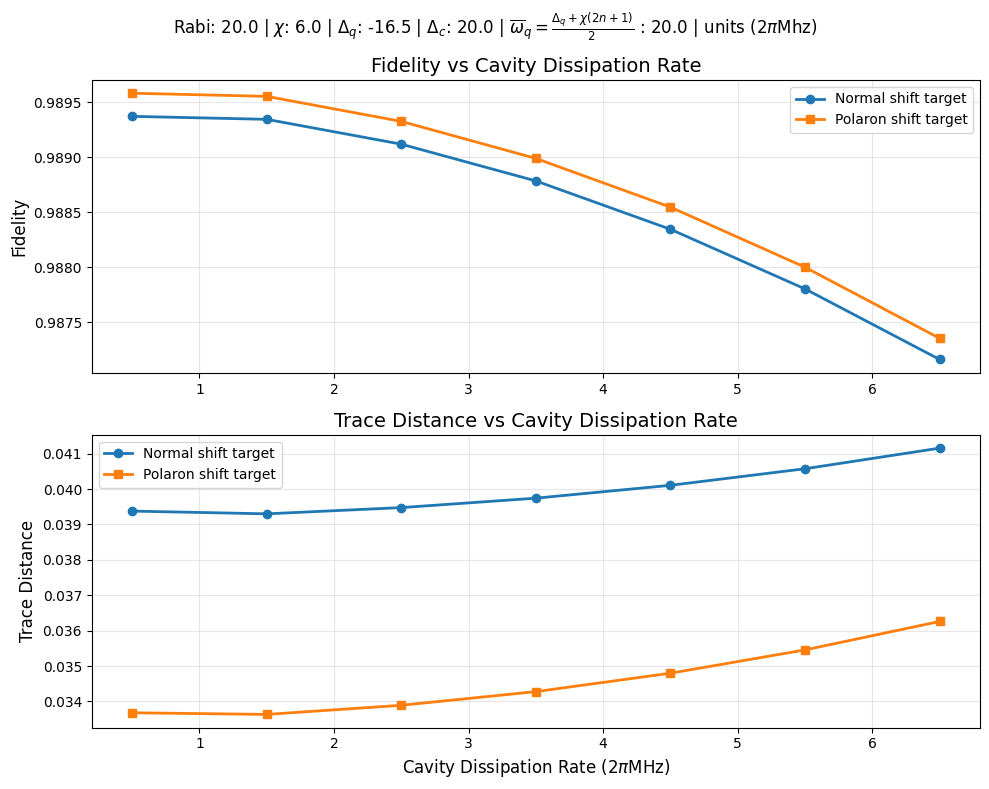

In [48]:
folder_path = "./cavity_diss_sweep_diff_point"
print(f"\nAnalyzing dynamics in folder: {folder_path}")
results = sweeps.analyze_cavity_diss_dependence(folder_path)

if results is not None:
    # Print summary
    print("\n=== Summary ===")
    print(f"Cavity dissipation rates analyzed: {results['cavity_diss_rates']} MHz")
    print(f"Fidelity (normal): {results['fidelity_normal']}")
    print(f"Fidelity (polaron): {results['fidelity_polaron']}")

    parameters = results['parameters']
    eff_coupling = parameters['eff_coupling']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    qubit_targetz = parameters['qubit_targetz']
    params_text = []
    params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\chi$"+f": {eff_coupling/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\overline{\omega}_q = \frac{\Delta_q +\chi(2n+1)}{2}$ "+f": {qubit_targetz/(2*np.pi*1e6):.1f}")
    params_text.append(r"units (2$\pi$Mhz)")

    # Create plots
    fig = sweeps.plot_cavity_diss_dependence(results)
    fig.suptitle(' | '.join(params_text), y=0.98)
    fig.tight_layout()


Analyzing dynamics in folder: ./qubit_targetz_sweep

=== Summary ===
Qubit target Z frequencies analyzed: [ 0.  5. 10. 15. 20. 25. 30.] MHz
Fidelity: [0.97469044 0.9770466  0.9817618  0.98607395 0.98937063 0.99151092
 0.99213733]
Trace distance: [0.05973883 0.06818679 0.0638641  0.05189075 0.03937706 0.02945241
 0.0235251 ]


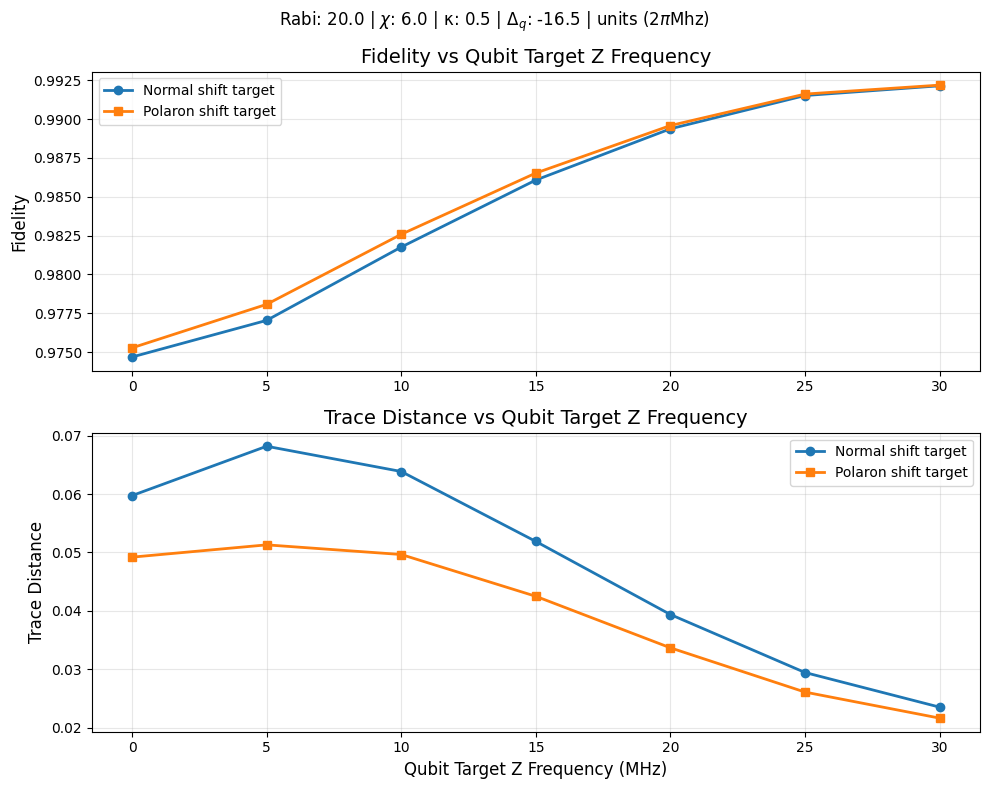

In [52]:
folder_path = "./qubit_targetz_sweep"
print(f"\nAnalyzing dynamics in folder: {folder_path}")

results = sweeps.analyze_qubit_targetz_dependence(folder_path)

if results is not None:
    # Print summary
    print("\n=== Summary ===")
    print(f"Qubit target Z frequencies analyzed: {results['qubit_targetz_rates']} MHz")
    print(f"Fidelity: {results['fidelity_normal']}")
    print(f"Trace distance: {results['trace_dist_normal']}")
    


    parameters = results['parameters']
    eff_coupling = parameters['eff_coupling']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    cavity_diss_rate = parameters['cavity_diss_rate']
    params_text = []
    params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\chi$"+f": {eff_coupling/(2*np.pi*1e6):.1f}")
    params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
    params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
    params_text.append(r"units (2$\pi$Mhz)")

    # Create plots
    fig = sweeps.plot_qubit_targetz_dependence(results)
    fig.suptitle(' | '.join(params_text), y=0.98)
    fig.tight_layout()